In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.circuit.library import ZGate, XGate
from qiskit import execute, Aer
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from pylab import *

In [2]:
def hsgs(N, vector):
    
    circuit = QuantumCircuit(N)
    
    phase = -1
    target_phase = phase
    
    # get the number of ones in each state
    vector_n_ones = get_number_of_ones(N)
    
    all_states_in_binary = get_all_states_in_binary(N)
    
    #print(vector)
    
    #print('::::::: case -|00...00>')
    # case: phase on |0> state, i.e.: -|00...00>
    if vector[0] == target_phase:
        # add Z gate to all qubits, we will have the phase in state |0> plus a global phase equal to -1
        circuit.z(range(N))
        # then the target phase should be inverted (due to the global phase of -1)
        target_phase *= phase
        # update other affected states
        for j in range(len(vector)):
            vector[j] *= phase**vector_n_ones[j]
        #print('updated because -|00...00>:', vector)
        # factor out a -1
        #vector *= phase
        #print('factor out a -1:', vector)
    
    
    #print('::::::: case only one |1>')
    # case: states with only one |1> in any qubit
    indices_with_one_1 = np.where(vector_n_ones == 1)[0]
    for j in indices_with_one_1:
        if vector[j] == target_phase:  # need a phase, then add a Z gate
            #print(all_states_in_binary[j])
            #qubit = np.where(np.flip(all_states_in_binary[j]) == 1)[0]
            qubit = np.where(all_states_in_binary[j] == 1)[0]
            #print('qubit =', qubit)
            circuit.z(N-1-qubit) # inverse order due to Qiskit order: |q1q0>
            # update other affected states
            update_other_phases(vector, all_states_in_binary, qubit, j, phase)
            #print(vector)
            
    
    #print('::::::: case p = 2, ..., N')
    # case: p = 2, ..., N
    for p in range(2, N+1):
        #print('p =',p)
        multiConrolledZ = ZGate().control(num_ctrl_qubits=p-1)
        indices_with_p_1s = np.where(vector_n_ones == p)[0]
        for j in indices_with_p_1s:
            if vector[j] == target_phase:  # need a phase, then add a C^pZ gate
                #print(all_states_in_binary[j])
                qubits = np.where(all_states_in_binary[j] == 1)[0]
                #print('qubits =', qubits)
                # inverse order due to Qiskit order: |q1q0>
                qubits_inverted = np.where(np.flip(all_states_in_binary[j]) == 1)[0]
                circuit.append(multiConrolledZ, list(qubits_inverted))
                # update other affected states
                update_other_phases(vector, all_states_in_binary, qubits, j, phase)
                #print(vector)
    
    return circuit

In [3]:
def get_binary_vector(N, k):
    convert_phases = lambda j: (-1)**j
    bitstring_array = np.array(list(format(k, '0'+str(2**N)+'b')), dtype=int)
    vfunc = np.vectorize(convert_phases)
    return vfunc(bitstring_array)

def get_number_of_ones(N):
    return np.array([n.bit_count() for n in range(2**N)])

def get_all_states_in_binary(N):
    return np.array([np.array(list(format(n, '0'+str(N)+'b')), dtype=int) for n in range(2**N)])

def update_other_phases(vector, all_states_in_binary, affected_qubits, j, phase):
    #print('affected_qubits =', affected_qubits)
    for i in range(j, len(vector)):
        #print('all_states_in_binary[',i,'] =', all_states_in_binary[i])
        #print('np.where(all_states_in_binary[',i,']==1)[0] =', np.where(all_states_in_binary[i]==1)[0])
        if all([elem in np.where(all_states_in_binary[i] == 1)[0] for elem in affected_qubits]):
            #print('entro a cambiar el vector')
            vector[i] *= phase
            #print(vector)

In [4]:
def U_i(N, ki, circuit):
    
    # create equal superposition
    circuit.h(range(N))
    
    # get vector i given the value ki
    vector_i = get_binary_vector(N, ki)
    
    # execute hsgs
    circuit.compose(hsgs(N, vector_i), inplace=True)

def U_w(N, kw, circuit):
    
    # get vector w given the value kw
    vector_w = get_binary_vector(N, kw)
    
    # execute hsgs
    circuit.compose(hsgs(N, vector_w), inplace=True)
    
    # apply Hadamards
    circuit.h(range(N))
    
    # apply NOTs
    circuit.x(range(N))

In [5]:
def perceptron_optimized(N, ki, kw, draw=False):
    
    # create circuit, N qubits + ancilla
    circuit = QuantumCircuit(N + 1, 1)
    
    # apply U_i
    U_i(N, ki, circuit)
    
    # apply U_w
    U_w(N, kw, circuit)
    
    # apply C^N X
    circuit.mcx(control_qubits=[i for i in range(N)], target_qubit=N)
    
    # measure the ancilla qubit
    circuit.measure(N, 0)
    
    # draw circuit
    if draw == True:
        display(circuit.draw('mpl'))
    
    return circuit

In [6]:
def draw_image(N, k):
        
    ns = format(k, '0'+str(2**N)+'b')
    
    fig, ax = plt.subplots(figsize=(2, 2))
        
    ax.grid(which='both', axis='both', linestyle='-', color='black', linewidth=1)

    cmap = colors.ListedColormap(['black', 'white']) # [0, 1]

    ax.set_xticks(np.arange(0.5, N, 1));
    ax.set_yticks(np.arange(0.5, N, 1));
    plt.tick_params(axis='both', which='both', bottom=False,   
                    left=False, labelbottom=False, labelleft=False)
    
    image_data = np.zeros((N, N))
    j = 0
    for (x,y), _ in np.ndenumerate(image_data):
        image_data[x][y] = int(ns[j])
        j += 1
    
    ax.imshow(image_data, cmap=cmap)
    
    plt.show()

### Training procedure

In [7]:
#load the previously generated training set
with open("training_set_3050.txt", "r") as file:
    training = eval(file.readline())

In [8]:
simulator = Aer.get_backend('aer_simulator')
shots = 10000

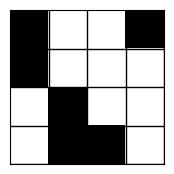

In [25]:
N = 4


w_0 = np.random.choice([-1, 1], size=2**N)
draw_image(N=N, k=int(''.join(['1' if j==-1 else '0' for j in w_0]), 2))

In [26]:
%%time

threshold = 0.5
l_p = 0.5
l_n = 0.5

w_t = w_0.copy()

kw_history = []

iteration = 0

for data in training:
    
    ki = data[0]
    kw = int(''.join(['1' if j==-1 else '0' for j in w_t]), 2)
    perceptron_circuit = perceptron_optimized(N, ki, kw)
    
    job = execute(perceptron_circuit, simulator, shots=shots)
    counts = job.result().get_counts(perceptron_circuit)
    if '1' in counts: probability_activated = counts['1']/shots
    else: probability_activated = 0
    
    if probability_activated > threshold: # perceptron was activated (positive label found)
        if data[1] == -1:                 # data point is labeled as negative
            # move w farther apart from i
            # flip a l_n fraction of signs, randomly select from components where i and w coincide
            vector_i = get_binary_vector(N, ki)
            coincidences = np.where(np.equal(vector_i, w_t))
            indices = np.random.choice(coincidences[0], size=int(len(coincidences[0])*l_n), replace=False)
            for index in indices:
                w_t[index] *= -1  # flip sign
    else:                                 # perceptron wasn't activated (negative label found)
        if data[1] == 1:                  # data point is labeled as positive
            # move w closer to i
            # flip a l_p fraction of signs, randomly select from components where i and w differ
            vector_i = get_binary_vector(N, ki)
            differences = np.where(np.logical_not(np.equal(vector_i, w_t)))
            indices = np.random.choice(differences[0], size=int(len(differences[0])*l_p), replace=False)
            for index in indices:
                w_t[index] *= -1  # flip sign
    
    kw_history.append(kw)
    
    iteration += 1
    print("\riteration = {}, kw = {}".format(iteration, kw), end="")  # looking for kw = 626
    
print()

iteration = 3050, kw = 64909
CPU times: total: 10min 40s
Wall time: 10min 43s


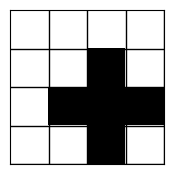

In [43]:
draw_image(N=N, k=kw_history[-1])

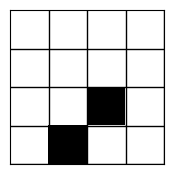

In [94]:
draw_image(N=N, k=kw_history[85])

In [49]:
# save training history in order to be able to reuse it
with open("training_history_for_cross_shape_pattern_one_trajectory.txt", "w") as file:
    file.write(str(kw_history))

In [48]:
#with open("training_history_for_cross_shape_pattern_one_trajectory.txt", "r") as file:
#    kw_history = eval(file.readline())

Calculate fidelity for the previous learning trajectory:

$$f=\left|\langle\psi_{w_t}\big|\psi_w\rangle\right|^2$$

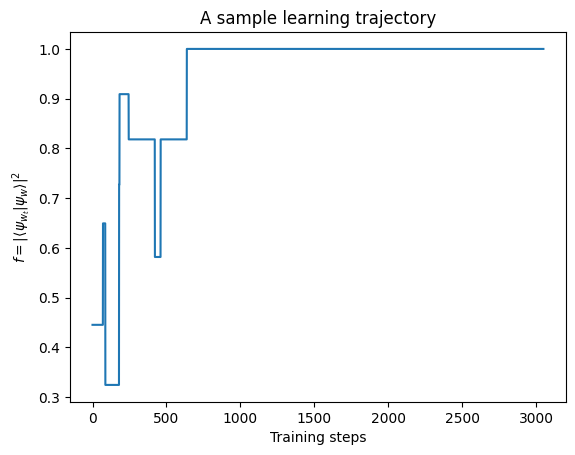

In [65]:
# plot the sample learning trajectory (one, stored in kw_history)

N = 4

kw_t = 64909
w_t_no_norm = np.array(list(format(kw_t, '0'+str(2**N)+'b')), dtype=int)
w_t = w_t_no_norm/np.linalg.norm(w_t_no_norm)

xs = range(len(training))

ys = []

# calculate fidelity for each element in history
for kw in kw_history:
    w_no_norm = np.array(list(format(kw, '0'+str(2**N)+'b')), dtype=int)
    w = w_no_norm/np.linalg.norm(w_no_norm)
    prod = np.vdot(w_t, w) # If first vector is complex the complex conjugate is taken before calculation
    ys.append(abs(prod)**2)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(xs, ys)

ax.set_title("A sample learning trajectory")
ax.set_xlabel('Training steps')
ax.set_ylabel('$f=\\left|\\langle\\psi_{w_t}|\\psi_w\\rangle\\right|^2$')

plt.show()

In [81]:
np.unique(ys)

array([0.32467532, 0.44545455, 0.58181818, 0.64935065, 0.72727273,
       0.81818182, 0.90909091, 1.        ])

In [93]:
np.where(np.isclose(ys, 0.64935065))

(array([71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86],
       dtype=int64),)

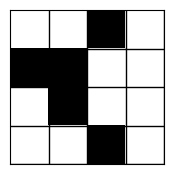

In [95]:
# selecting same w_0 as in paper

N = 4


w_0_given = [-1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1]
draw_image(N=N, k=int(''.join(['1' if j==-1 else '0' for j in w_0_given]), 2))

In [96]:
%%time

threshold = 0.5
l_p = 0.5
l_n = 0.5

w_t = w_0_given.copy()

kw_history = []

iteration = 0

for data in training:
    
    ki = data[0]
    kw = int(''.join(['1' if j==-1 else '0' for j in w_t]), 2)
    perceptron_circuit = perceptron_optimized(N, ki, kw)
    
    job = execute(perceptron_circuit, simulator, shots=shots)
    counts = job.result().get_counts(perceptron_circuit)
    if '1' in counts: probability_activated = counts['1']/shots
    else: probability_activated = 0
    
    if probability_activated > threshold: # perceptron was activated (positive label found)
        if data[1] == -1:                 # data point is labeled as negative
            # move w farther apart from i
            # flip a l_n fraction of signs, randomly select from components where i and w coincide
            vector_i = get_binary_vector(N, ki)
            coincidences = np.where(np.equal(vector_i, w_t))
            indices = np.random.choice(coincidences[0], size=int(len(coincidences[0])*l_n), replace=False)
            for index in indices:
                w_t[index] *= -1  # flip sign
    else:                                 # perceptron wasn't activated (negative label found)
        if data[1] == 1:                  # data point is labeled as positive
            # move w closer to i
            # flip a l_p fraction of signs, randomly select from components where i and w differ
            vector_i = get_binary_vector(N, ki)
            differences = np.where(np.logical_not(np.equal(vector_i, w_t)))
            indices = np.random.choice(differences[0], size=int(len(differences[0])*l_p), replace=False)
            for index in indices:
                w_t[index] *= -1  # flip sign
    
    kw_history.append(kw)
    
    iteration += 1
    print("\riteration = {}, kw = {}".format(iteration, kw), end="")  # looking for kw = 626
    
print()

iteration = 3050, kw = 64909
CPU times: total: 9min 30s
Wall time: 9min 26s


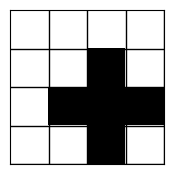

In [97]:
draw_image(N=N, k=kw_history[-1])

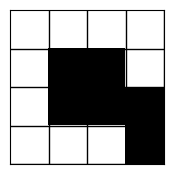

In [98]:
draw_image(N=N, k=kw_history[85])

In [99]:
# save training history in order to be able to reuse it
with open("training_history_for_cross_shape_pattern_one_trajectory_given_w0.txt", "w") as file:
    file.write(str(kw_history))

In [100]:
#with open("training_history_for_cross_shape_pattern_one_trajectory_given_w0.txt", "r") as file:
#    kw_history = eval(file.readline())

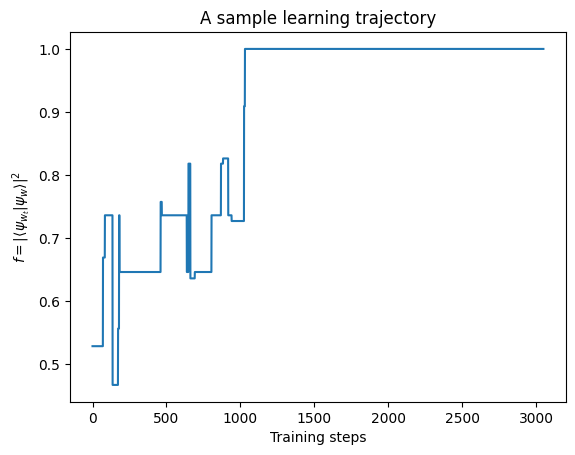

In [101]:
# plot the sample learning trajectory (one, stored in kw_history)

N = 4

kw_t = 64909
w_t_no_norm = np.array(list(format(kw_t, '0'+str(2**N)+'b')), dtype=int)
w_t = w_t_no_norm/np.linalg.norm(w_t_no_norm)

xs = range(len(training))

ys = []

# calculate fidelity for each element in history
for kw in kw_history:
    w_no_norm = np.array(list(format(kw, '0'+str(2**N)+'b')), dtype=int)
    w = w_no_norm/np.linalg.norm(w_no_norm)
    prod = np.vdot(w_t, w) # If first vector is complex the complex conjugate is taken before calculation
    ys.append(abs(prod)**2)
    
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(xs, ys)

ax.set_title("A sample learning trajectory")
ax.set_xlabel('Training steps')
ax.set_ylabel('$f=\\left|\\langle\\psi_{w_t}|\\psi_w\\rangle\\right|^2$')

plt.show()